# K Nearest Neighbors

This is a rather simple algorithm that assigns new, unlabeled datapoints a label. It works by calculating the distance of the datapoint to the nearest cluster, usually the center of that cluster, and then setting that cluster as the label for the datapoint. In order for this work you need a dataset with labels. These could be assigned using K means or any other unsupervised learning algorithm.

## Algorithm

1. Begin with a labeled dataset and new datapoints for that dataset that do not yet have labels.
2. Calculate the point in the labeled cluster you will use to measure distance from. This is usually the center of the cluster but can be different depending on the specific use case. In this notebook I'll take the mean of all datapoints in each cluster to use as the center.
3. For each datapoint in the new, unlabeled data, calculate the distance from that point to each cluster.
4. Assign the point to the closest cluster.

## Some metrics for measuring distance

Measuring the distance between two points can be done in many different ways. When choosing a way to measure distance for KNN it is important to make sure the metric you choose works well for the task at hand. For example, the cosine similarity could be used, but it doesn't perform well with the dataset in this notebook. For further reading on distance metrics [this paper](https://arxiv.org/pdf/1708.04321.pdf) does a good job summarizing the pros and cons of the most common methods. This notebook uses the following.

### Euclidean distance

You can think of this as an extension of the pythagorean theorem. This is the straight line distance between two points.

$D(x,c) = \sqrt{(x_1-c_1)^2+(x_2-c_2)^2+\dots+(x_n-c_n)^2} = \sqrt{\sum_{i=1}^n (x_i - c_i)^2}$

Where:
- $x_i$ is the $i^{th}$ datapoint and $c_i$ is the center of a cluster


### Manhattan distance

This is also called the taxi cab distance. It does not move in diagonals, measuring the sum of absolute differences. It can be robust to outliers.

$D(x,c) = |x_1-c_1|+|x_2-c_2|+\dots+|x_n-c_n| = \sum_{i=1}^n |x_i - c_i)|$



### Chebyshev distance

The maximum absolute difference between two points.

$D(x,c) = max_i |x_i - c_i |$


### Minkowski distance

This is a blend of the Euclidean and Manhattan distances.

$D(x,c) = ((x_1-c_1)^p+(x_2-c_2)^p+\dots+(x_n-c_n)^p)^{1/p} = (\sum_{i=1}^n (x_i - c_i)^p)^{1/p}$

Where:
- $p$ is the any real number
- When $p=1$ this becomes the manhattan distance
- When $p=2$ this becomes the euclidean distance


### Cosine similarity

While the cosine similarity could be used, you will see it does not work for the task at hand here. In other situations it may perform better.

$D(x,c) = \frac{x \dot c}{||x|| * ||c||}$

- The dot product of $x$ and $c$ over the magnitude of $x$ multiplied by the magnitude of $c$


## Limitations

Depending on the distance metric, the labels produced for new datapoints may differ from what is expected or may be sub optimal. It is important to experiment to ensure you are getting labels you feel accurately represent the new datapoints.

## Complexity

Time complexity:
- There's no training phase with KNN so this is a constant $O(1)$

Space complexity
- Either $O(nd)$ for a brute force approach or $O(dlogn)$ for a tree based approach
- $d$ is the dimensions of the data
- $n$ is the number of datapoints
- Brute force would be calculating the distance between every point, sorting them, then selecting the nearest neighbor (like this notebook)
- Tree based approaches use some sort of tree structure to organize the data for the algorithm. These can be faster in lower dimensional space.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs 
np.random.seed(0)

In [2]:
# make some blobs
n_clusters = 3  # Number of clusters
cluster_std = 1.0  # Standard deviation of each cluster
n_samples = 300  # Total number of data points

# Define cluster centers
cluster_centers = np.array([
    [2, 2],
    [8, 3],
    [4, 6]
])

In [3]:
X, y = make_blobs(n_samples=n_samples, centers=cluster_centers, cluster_std=cluster_std)
print(X.shape, y.shape)

(300, 2) (300,)


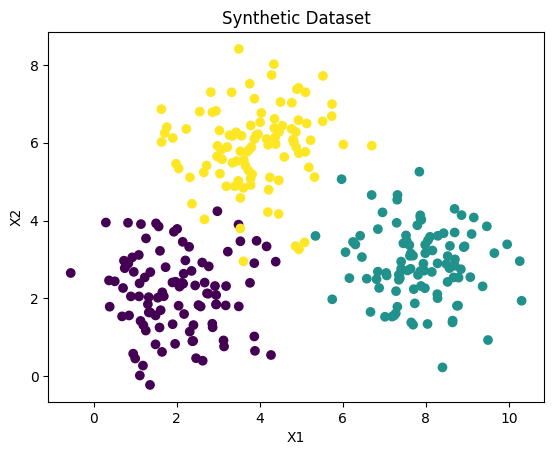

In [4]:
plt.scatter(X[:,0],X[:,1], c = y)
plt.title("Synthetic Dataset")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [5]:
# create new datapoints
x_new = np.c_[np.random.randint(0,10, size = 5) + np.random.random(5), np.random.randint(0,10, size = 5) + np.random.random(5)]

In [6]:
class KNN():
    def __init__(self, data, labels, x, **kwargs):
        self.metric = kwargs.get('metric', 'euclidean')
        self.p = kwargs.get('p', 1.5) # 1 is manhattan, 2 euclidean, can be any real number
        self.data = data
        self.clusters = None
        self.labels = labels
        self.x = x
        self.y = np.zeros((self.x.shape[0]))
        self.centers = self.find_centers(labels)


    def find_centers(self, labels):
        """gets centers for clusters"""
        
        self.clusters = np.array(labels) if type(labels) != np.ndarray else labels
        self.clusters = np.unique(self.clusters)

        centers = np.zeros_like((self.clusters,self.clusters), dtype = np.float64).T
        if self.metric == 'cos':
            # data should be normalized before using cos similarity for this purpose
            self.x /= np.linalg.norm(self.x)
        
        for i in range(len(centers)):
            centers[i,:] = np.mean(self.data[self.labels == i], axis = 0)

        return centers

    
    def get_dist(self, x):
        """gets distance between points for specified method"""
        
        if self.metric == 'euclidean':
            # straight-line distance between two points in Euclidean space
            dist = np.sqrt(np.sum(np.square(x-self.centers), axis = 1, keepdims = True))
        elif self.metric == 'manhattan':
            # sum of the absolute differences between the coordinates of the points
            dist = np.sum(abs(x-self.centers), axis = 1, keepdims = True)
        elif self.metric == 'chebyshev':
            # max absolute difference between the coordinates of the points
            dist = np.max(abs(x-self.centers), axis = 1, keepdims = True)
        elif self.metric == 'minkowski':
            # generalization of the Euclidean and Manhattan distances
            dist = np.power(np.sum(abs(x-self.centers)**self.p, axis = 1, keepdims = True), 1/self.p)
        elif self.metric == 'cos':
            # cosine of the angle between two vectors
            # used when the magnitude of the vectors is not important, only the direction
            # does not work on this demo
            dist = (x @ self.centers.T)/(np.linalg.norm(x) * np.linalg.norm(self.centers, axis = 1))

        return np.argmin(dist)


    def fit(self):
        """assigns new data points to cluster based on criteria"""
        
        for i, x in enumerate(self.x):
            self.y[i] = self.get_dist(x)


In [8]:
def try_each_metric(metric):
    """tries each distance metric to see how they compare"""
    
    plt.scatter(X[:,0],X[:,1], c = y)
    plt.scatter(x_new[:,0],x_new[:,1], c = 'red')
    plt.title("Synthetic Dataset")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.show()
    
    knn = KNN(X, y, x_new, metric = metric)
    knn.fit()
    
    new_data = np.r_[X, x_new]
    y_new = np.r_[y, knn.y]
    plt.scatter(new_data[:,0],new_data[:,1], c = y_new)
    plt.title("Synthetic Dataset")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.show()

### Below we run the data through the KNN algorithm using different distance metrics

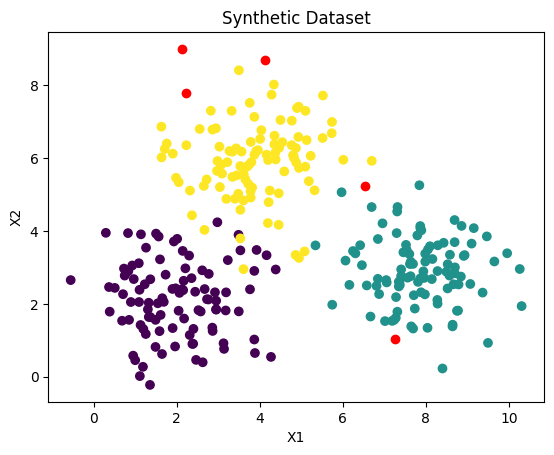

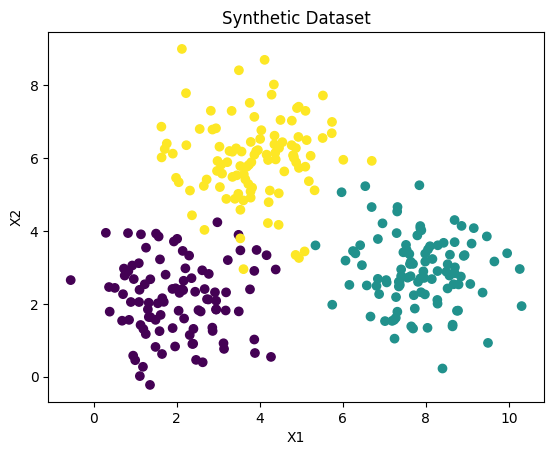

In [9]:
try_each_metric(metric = 'euclidean')

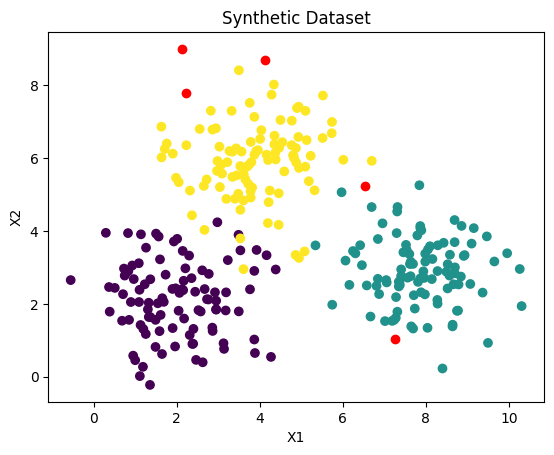

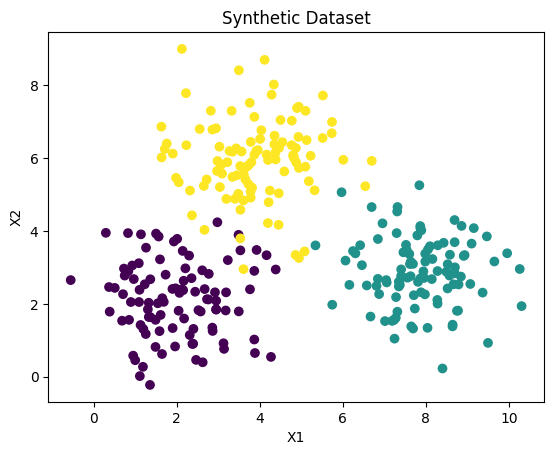

In [10]:
try_each_metric(metric = 'manhattan')

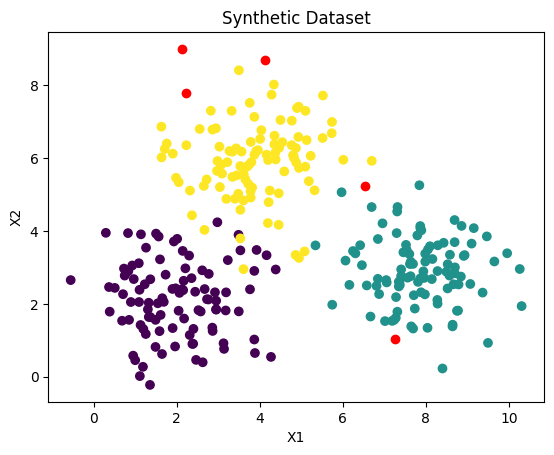

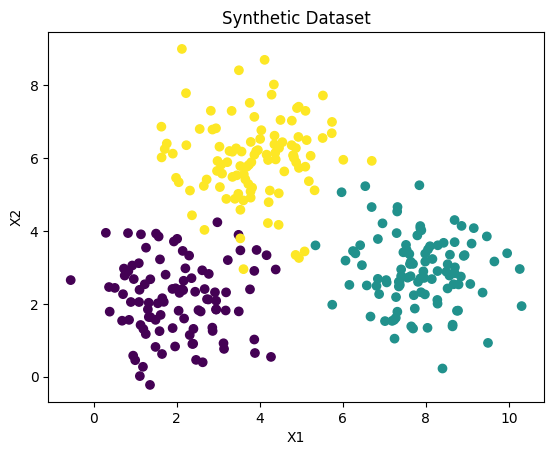

In [11]:
try_each_metric(metric = 'chebyshev')

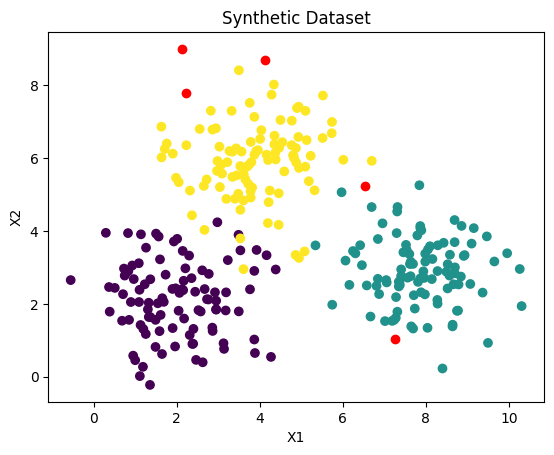

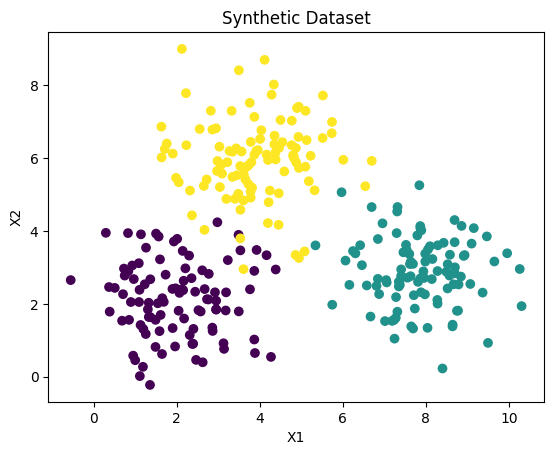

In [12]:
try_each_metric(metric = 'minkowski')

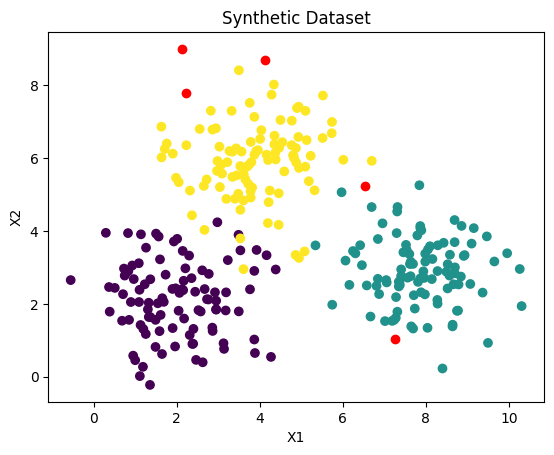

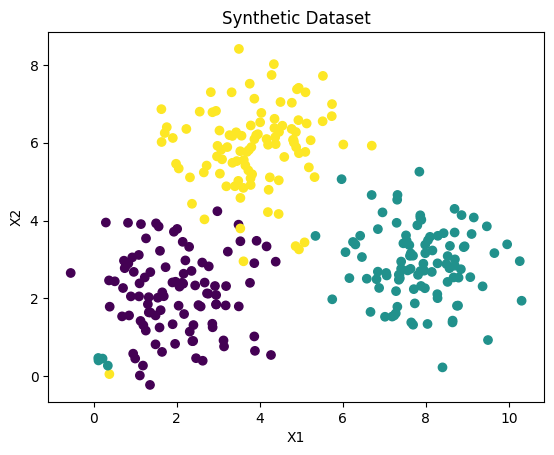

In [13]:
try_each_metric(metric = 'cos')